<a href="https://colab.research.google.com/github/MrPr3ntice/da_examples/blob/main/da_example_ot_alignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
# install Python Optimal Transport
# Reference:
#  Rémi Flamary et al.
#  POT Python Optimal Transport library,
#  Journal of Machine Learning Research, 22(78):1−8, 2021.
#  Website: https://pythonot.github.io/
!pip install POT

import ot
from matplotlib import pyplot as plt
import matplotlib
from sklearn.datasets import make_classification
from sklearn.base import clone
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.preprocessing import FunctionTransformer as FT
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
import numpy as np

# for better reproducibility
np.random.seed(2022)

# Helper functions

In [ ]:
# define scoring function
def my_scorer(est, X_s, y_s, X_t, y_t):
  # randomly split first dataset
  X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(
      X_s, y_s, test_size=0.50, stratify=y_s
  )
  est.fit(X_s_train, y_s_train)
  print('Train ACC (on source domain): ', est.score(X_s_train, y_s_train))
  print('Test ACC (on source domain): ', est.score(X_s_test, y_s_test))
  # DA
  print('Test ACC (on target domain): ', est.score(X_t, y_t))
  print('Base rate ACC:', DummyClassifier(strategy='most_frequent').fit(X_s_train, y_s_train).score(X_t, y_t))

# define plotting function
def plot_datasets(dataset_list, n=1500, ax=None, names=None):
  if ax is None:
    ax = plt.gca()
  markers = ['o', 's', '+', 'v', 'x', '8']
  for i, data in enumerate(dataset_list):
    x, y = data
    labels_unique, labels_for_c = np.unique(y, return_inverse=True)
    cmap = plt.cm.rainbow
    norm = matplotlib.colors.Normalize(vmin=-1, vmax=len(labels_unique)-1)
    if i == 2:
      alpha = 1
    else:
      alpha = 0.4
    for j, lab in enumerate(labels_unique):
      x_j = x[labels_for_c == j, :]
      n_j = min(n, x_j.shape[0])
      if names is None:
        name_i = str(i)
      else:
        name_i = names[i]
      ax.scatter(x_j[:n_j, 0],
                 x_j[:n_j, 1],
                 label='dataset: ' + name_i + ', class: ' + str(lab),
                 cmap='jet',
                 marker=markers[np.mod(i, len(markers))],
                 edgecolor=(0,0,0,1),
                 color=cmap(norm(lab)),
                 s=100,
                 alpha=alpha)
  ax.legend()
  ax.grid(True)
  ax.axis('equal')

def my_split(X, y, prop=[0.5, 0.5]):
  n = len(y)
  prop = np.asarray(prop)
  prop = prop / np.sum(prop)
  ns = np.around(prop * n)
  ns[-1] += n - sum(ns) 
  idx = []
  for j, i in enumerate(ns):
    idx += [j] * int(i)
  idx = np.asarray(idx)
  np.random.shuffle(idx)
  out = []
  for i in range(len(prop)):
    out.append(X[idx == i])
    out.append(y[idx == i])
  return out

# defining dataset function
def get_example_dataset(c_classes=2, n_s=500, n_t=100, class_sep=1.0, flip_rot=True):
  # generate base dataset
  X, y = make_classification(
      n_samples = n_s + n_t,
      n_features=2,
      n_informative=2,
      n_redundant=0,
      n_repeated=0,
      n_classes=c_classes,
      n_clusters_per_class=1,
      weights=None,
      flip_y=0.0,
      class_sep=class_sep,
      hypercube=True,
      shift=0.0,
      scale=1.0,
      shuffle=False,
      random_state=None
  )

  # split datasets from base dataset
  X_s, y_s, X_t, y_t = my_split(X, y, [n_s, n_t])

  # (affine) transform 2nd dataset 
  # random rotation
  theta = np.random.rand() * 2 * np.pi
  rotMatrix = np.array([[np.cos(theta), -np.sin(theta)], 
                        [np.sin(theta),  np.cos(theta)]])
  # random noise, shift, flip, shear and scale
  rand_flip_vec = np.asarray([np.sign(np.random.normal()), 1])
  rand_scale_vec = np.random.normal(1.4, 0.4, 2)
  rand_shear_mat = np.eye(2)
  rand_shear_mat[0, 1] =  np.random.normal(0, 0.5)
  rand_shift = np.random.normal(10, 1, 2)
  if not flip_rot:
    rand_flip_vec = np.asarray([1, 1])
    theta = (np.random.rand()-0.5) * 0.2 * 2 * np.pi
    rotMatrix = np.array([[np.cos(theta), -np.sin(theta)], 
                          [np.sin(theta),  np.cos(theta)]])
  print('rot: ', rotMatrix)
  print('flip: ', rand_flip_vec)
  print('scale: ', rand_scale_vec)
  print('shear: ', rand_shear_mat)
  print('shift: ', rand_shift)
  X_t = np.dot(np.dot((X_t + np.random.normal(0, 0.15, X_t.shape)), rotMatrix) * rand_flip_vec * rand_scale_vec, rand_shear_mat) + rand_shift
  # X_t = X_s + + np.random.normal(20, 1, 2)

  return X_s, y_s, X_t, y_t

# Generate datasets

rot:  [[ 0.90103019  0.43375637]
 [-0.43375637  0.90103019]]
flip:  [1 1]
scale:  [1.12392528 1.89277424]
shear:  [[1.         0.21783303]
 [0.         1.        ]]
shift:  [10.57830926 11.29233552]


Text(0.5, 1.0, 'Source and target domain')

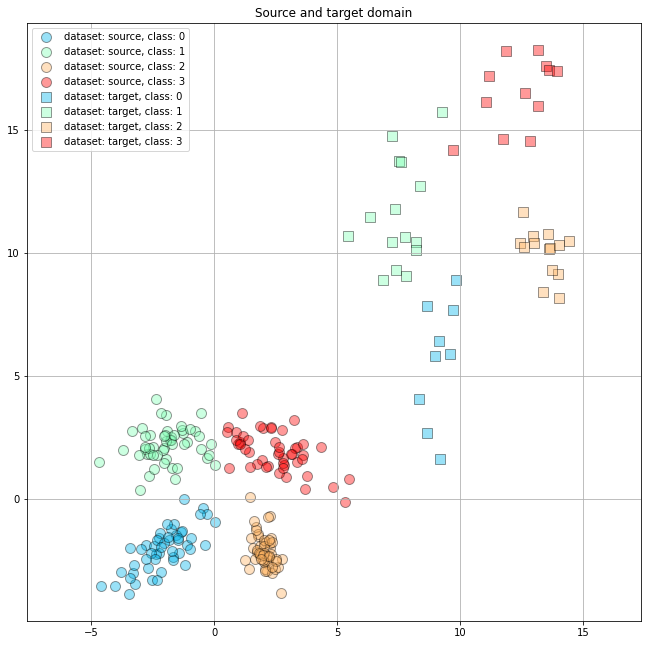

In [ ]:
# new data
X_s, y_s, X_t, y_t = get_example_dataset(c_classes=4, n_s=200, n_t=100, class_sep=2, flip_rot=False)
X_s_train, y_s_train, X_s_test, y_s_test = my_split(X_s, y_s, [0.5, 0.5])
X_t_train, y_t_train, X_t_test, y_t_test = my_split(X_t, y_t, [0.5, 0.5])

# plot
plt.subplots(figsize=(11, 11))
plot_datasets([(X_s, y_s), (X_t_train, y_t_train)], names=['source', 'target'])
plt.title('Source and target domain')

# Unsupervised OT

/usr/local/lib/python3.7/dist-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


Train ACC (on source domain):  0.99
Test ACC (on source domain):  0.99
Test ACC (on target domain):  0.72
Base rate ACC: 0.2


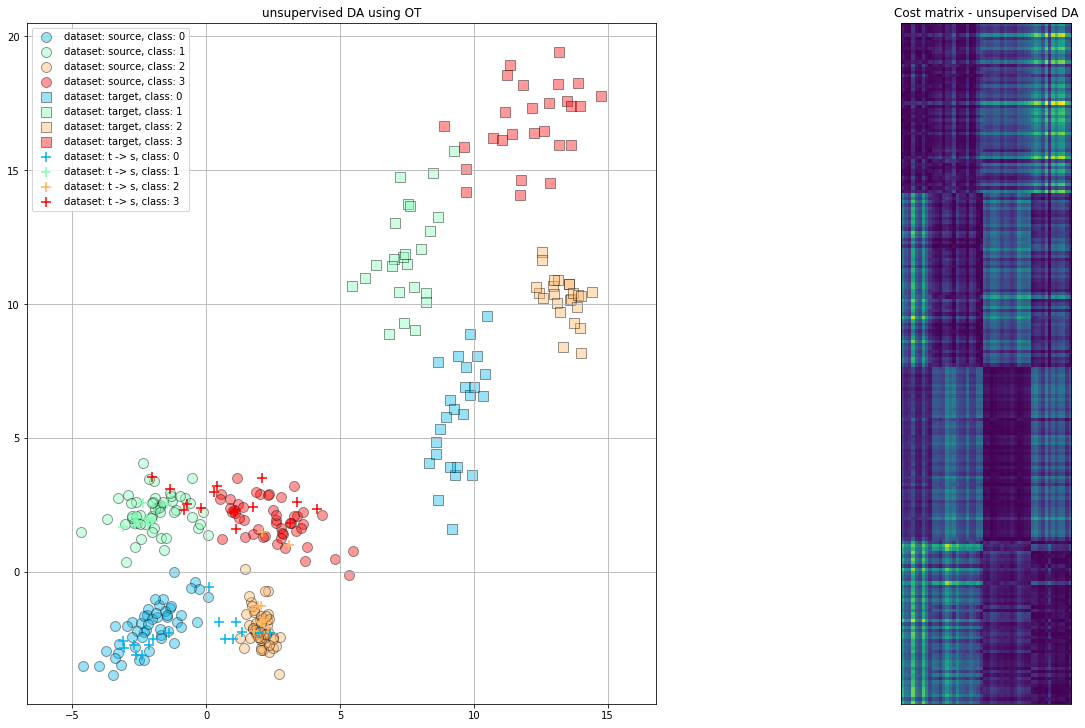

In [ ]:
# unsupervised domain adaptation
# Sinkhorn Transport with Group lasso regularization
ot_sinkhorn_un = ot.da.SinkhornLpl1Transport(max_iter=10, max_inner_iter=200, reg_e=0.09, reg_cl=1e0)
scaler_s = StandardScaler().fit(X_s)
scaler_t = StandardScaler().fit(X_t_train)
ot_sinkhorn_un.fit(Xs=scaler_s.transform(X_s), ys=y_s,
                   Xt=scaler_t.transform(X_t_train))
X_t_test_aligned_sinkhorn_un = scaler_s.inverse_transform(
    ot_sinkhorn_un.inverse_transform(Xt=scaler_t.transform(X_t_test)))

# plot
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(18, 10),
                        constrained_layout=True)
plot_datasets([(X_s, y_s), (X_t, y_t), (X_t_test_aligned_sinkhorn_un, y_t_test)], ax=axs[0], names=['source', 'target', 't -> s'])
axs[0].set_title('unsupervised DA using OT')
axs[1].imshow(ot_sinkhorn_un.cost_, interpolation='nearest')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title('Cost matrix - unsupervised DA')

# estimate
my_scorer(SVC(), X_s, y_s, X_t_test_aligned_sinkhorn_un, y_t_test)

# (Semi-)Supervised OT

rot:  [[ 0.5133896   0.85815565]
 [-0.85815565  0.5133896 ]]
flip:  [1. 1.]
scale:  [1.03916668 1.75294115]
shear:  [[1.         0.77739697]
 [0.         1.        ]]
shift:  [ 9.84915097 10.48567324]


Text(0.5, 1.0, 'Source and target domain')

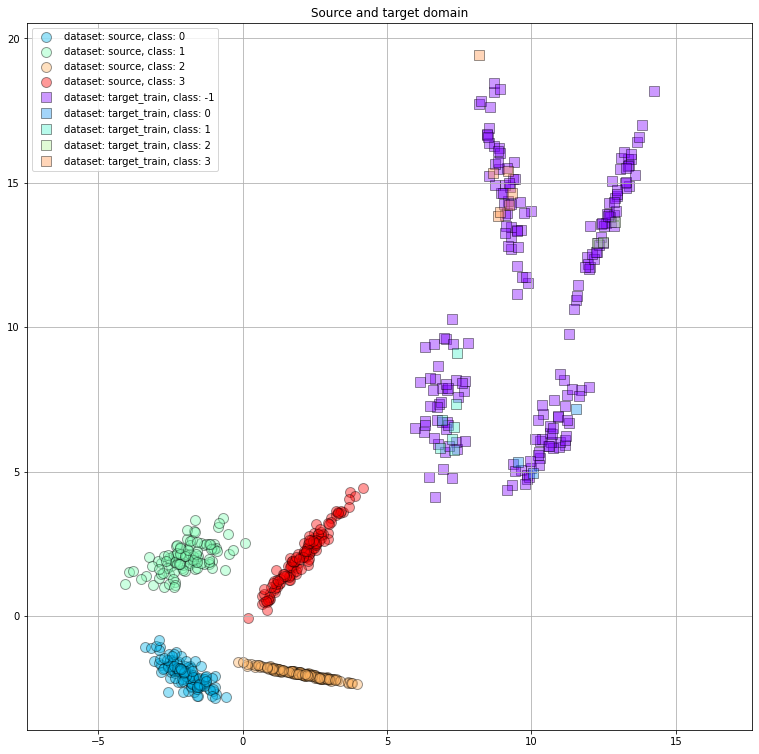

In [ ]:
# new data
n_t_train_labeled = 200
n_t_train_unlabeled = 20
n_t_test = 1000
n_s = 500

n_t_train = n_t_train_labeled + n_t_train_unlabeled
n_t = n_t_train + n_t_test

X_s, y_s, X_t, y_t = get_example_dataset(c_classes=4, n_s=n_s, n_t=n_t, class_sep=2, flip_rot=True)
X_t_train, y_t_train, X_t_test, y_t_test = my_split(X_t, y_t, [n_t_train, n_t_test])
y_t_train_orig = y_t_train.copy()

# erase label info from target's labeled train data
idx_labeled = np.asarray([True] * n_t_train_labeled + [False] * n_t_train_unlabeled)
np.random.shuffle(idx_labeled)
y_t_train[idx_labeled] = -1

# plot datasets
plt.subplots(figsize=(13, 13))
plot_datasets([(X_s, y_s), (X_t_train, y_t_train)], names=['source', 'target_train'])
plt.title('Source and target domain')

/usr/local/lib/python3.7/dist-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


Train ACC (on source domain):  1.0
Test ACC (on source domain):  1.0
Test ACC (on target domain):  0.195
Base rate ACC: 0.228


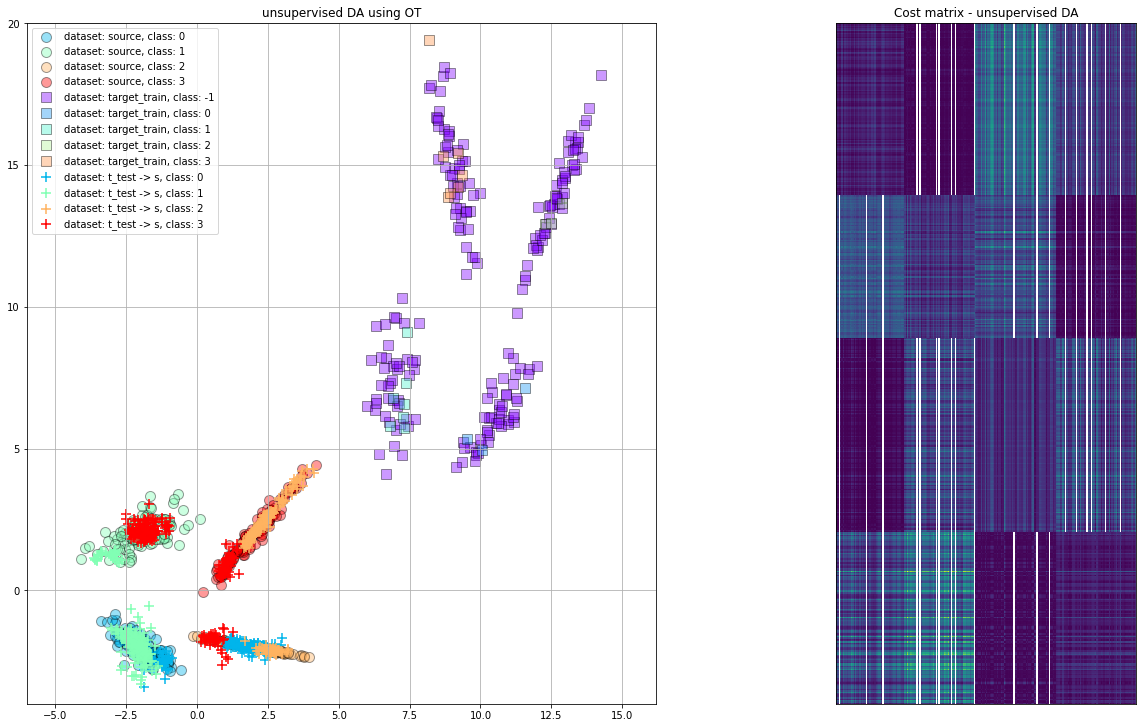

In [ ]:
# semi-supervised domain adaptation
# Sinkhorn Transport with Group lasso regularization
ot_sinkhorn_semi = ot.da.SinkhornLpl1Transport(max_iter=10, max_inner_iter=200, reg_e=0.1, reg_cl=1)
scaler_s = StandardScaler().fit(X_s)
scaler_t = StandardScaler().fit(X_t_train)
ot_sinkhorn_semi.fit(Xs=scaler_s.transform(X_s), ys=y_s,
                     Xt=scaler_t.transform(X_t_train), yt=y_t_train)
X_t_test_aligned_sinkhorn_semi = scaler_s.inverse_transform(
    ot_sinkhorn_semi.inverse_transform(Xt=scaler_t.transform(X_t_test)))

# plot
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(18, 10),
                        constrained_layout=True)
plot_datasets([(X_s, y_s), (X_t_train, y_t_train), (X_t_test_aligned_sinkhorn_semi, y_t_test)], ax=axs[0], names=['source', 'target_train', 't_test -> s'])
axs[0].set_title('unsupervised DA using OT')
axs[1].imshow(ot_sinkhorn_semi.cost_, interpolation='nearest')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title('Cost matrix - unsupervised DA')

# estimate
my_scorer(SVC(), X_s, y_s, X_t_test_aligned_sinkhorn_semi, y_t_test)

/usr/local/lib/python3.7/dist-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/usr/local/lib/python3.7/dist-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


Train ACC (on source domain):  1.0
Test ACC (on source domain):  1.0
Test ACC (on target domain):  0.981
Base rate ACC: 0.228


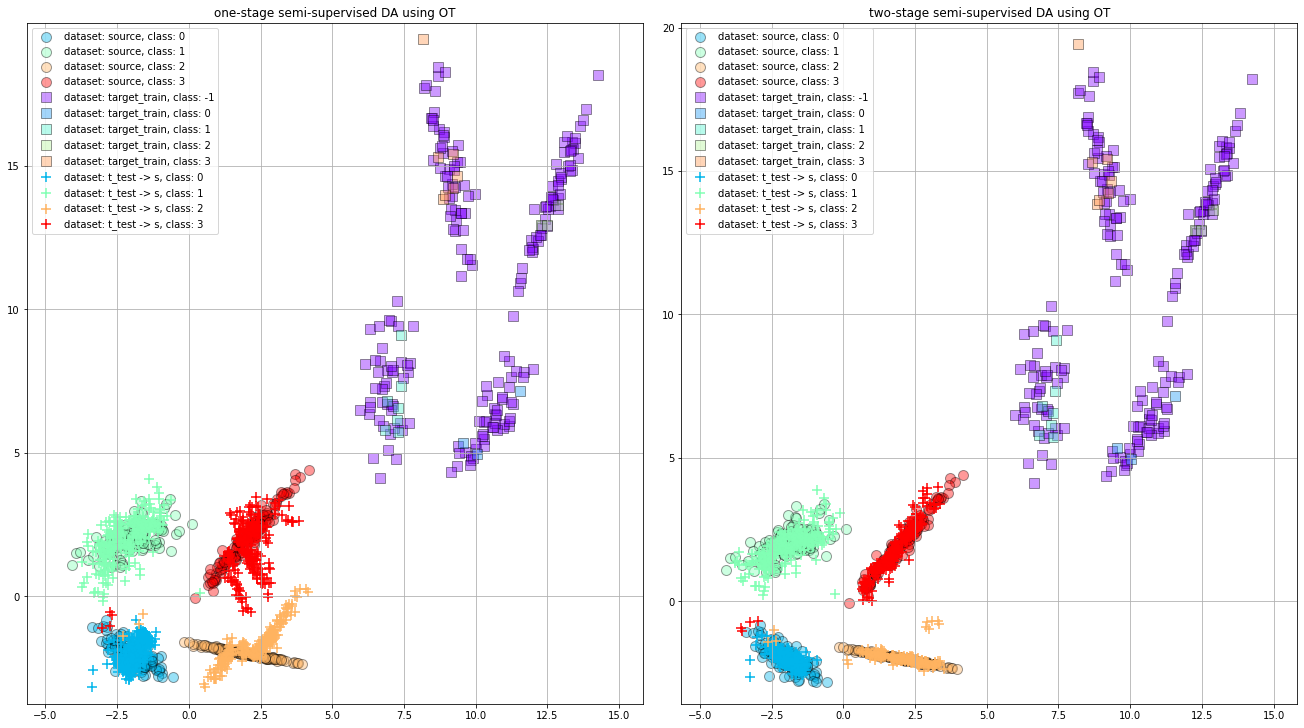

In [ ]:
# two-stage semi-supervised domain adaptation
X_t_train_labeled = X_t_train[y_t_train != -1]
y_t_train_labeled = y_t_train[y_t_train != -1]
X_t_train_unlabeled = X_t_train[y_t_train == -1]
y_t_train_unlabeled = y_t_train[y_t_train == -1]


# Sinkhorn Transport with Group lasso regularization
ot_sinkhorn_semi_su = ot.da.SinkhornLpl1Transport(max_iter=10, max_inner_iter=200, reg_e=0.1, reg_cl=1)
ot_sinkhorn_semi_un = ot.da.SinkhornTransport(max_iter=10, reg_e=0.05)
scaler_s = StandardScaler().fit(X_s)
scaler_t = StandardScaler().fit(X_t_train)

ot_sinkhorn_semi_su.fit(Xs=scaler_s.transform(X_s), ys=y_s,
                        Xt=scaler_t.transform(X_t_train_labeled), yt=y_t_train_labeled)
ot_sinkhorn_semi_un.fit(Xs=scaler_s.transform(X_s),
                        Xt=ot_sinkhorn_semi_su.inverse_transform(Xt=scaler_t.transform(X_t_train_unlabeled)))

X_t_test_aligned_sinkhorn_semi = scaler_s.inverse_transform(
    ot_sinkhorn_semi_su.inverse_transform(
        Xt=scaler_t.transform(X_t_test)))
X_t_test_aligned_sinkhorn_semi_two = scaler_s.inverse_transform(
    ot_sinkhorn_semi_un.inverse_transform(
        Xt=ot_sinkhorn_semi_su.inverse_transform(
            Xt=scaler_t.transform(X_t_test))))

# plot
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(18, 10),
                        constrained_layout=True)
plot_datasets([(X_s, y_s), (X_t_train, y_t_train), (X_t_test_aligned_sinkhorn_semi, y_t_test)], ax=axs[0], names=['source', 'target_train', 't_test -> s'])
axs[0].set_title('one-stage semi-supervised DA using OT')
#axs[1].imshow(ot_sinkhorn_semi_un.coupling_, interpolation='nearest')
#axs[1].set_xticks([])
#axs[1].set_yticks([])
#axs[1].set_title('Cost matrix - unsupervised DA')
plot_datasets([(X_s, y_s), (X_t_train, y_t_train), (X_t_test_aligned_sinkhorn_semi_two, y_t_test)], ax=axs[1], names=['source', 'target_train', 't_test -> s'])
axs[1].set_title('two-stage semi-supervised DA using OT')

# estimate
my_scorer(SVC(), X_s, y_s, X_t_test_aligned_sinkhorn_semi, y_t_test)